In [48]:
import importlib
import finetune_hub.config
import finetune_hub.data
import finetune_hub.engine
import finetune_hub.trainer
import finetune_hub.inference
import finetune_hub.adapter

# Reload everything to be safe
importlib.reload(finetune_hub.config)
importlib.reload(finetune_hub.data)
importlib.reload(finetune_hub.engine)
importlib.reload(finetune_hub.trainer)
importlib.reload(finetune_hub.inference)
importlib.reload(finetune_hub.adapter)

# Re-import cleanly
from finetune_hub import (
    ModelConfig,
    VLMEngine,
    DataProcessor,
    TrainerWrapper,
    InferenceEngine
)

print("All modules reloaded and classes updated!")

All modules reloaded and classes updated!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
%cd /content/drive/MyDrive/Colab Notebooks/Vee

/content/drive/MyDrive/Colab Notebooks/Vee


In [15]:
# !pip install -q -U torch torchvision torchaudio transformers datasets peft bitsandbytes accelerate

In [16]:
from huggingface_hub import login
from google.colab import userdata

# This automatically pulls the key from the sidebar
try:
    login(token=userdata.get('HF_TOKEN'))
    print("✅ Auto-login successful!")
except Exception as e:
    print("❌ Auto-login failed. Please verify your 'HF_TOKEN' secret.")

✅ Auto-login successful!


In [17]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import random

# 1. Load a tiny slice of the dataset (streaming mode saves RAM)
print("Loading dataset info...")
ds = load_dataset("deepcopy/MathWriting-human", split="train", streaming=True)

Loading dataset info...


Dataset loaded. Fetching samples...



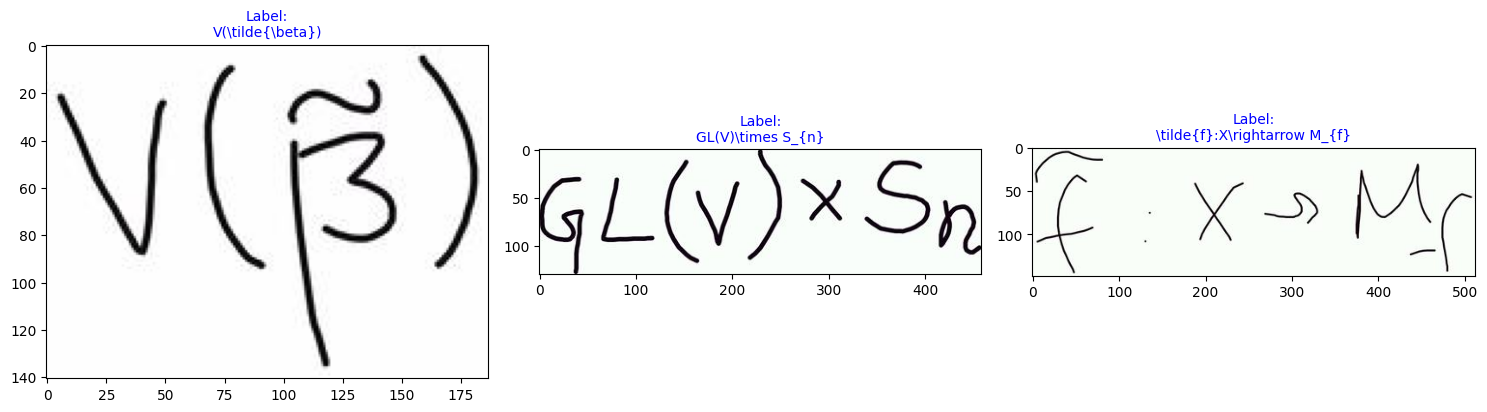

In [18]:
# 2. Get a few samples
print("Dataset loaded. Fetching samples...\n")
samples = list(ds.take(3))  # Grab first 3 examples

# 3. Visualize them
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, sample in enumerate(samples):
    # Get image and label
    image = sample["image"]
    label = sample["latex"]

    # Plot image
    axes[i].imshow(image)
    # axes[i].axis("off")

    # formatting the title to prevent it from being too long
    display_label = label[:50] + "..." if len(label) > 50 else label
    axes[i].set_title(f"Label:\n{display_label}", fontsize=10, color="blue")

plt.tight_layout()
plt.show()

In [19]:
print("\n--- Detailed Inspection of Sample 1 ---")
print(f"Keys available: {samples[0].keys()}")
print(f"Full LaTeX: {samples[0]['latex']}")
print(f"Image Size: {samples[0]['image'].size}")


--- Detailed Inspection of Sample 1 ---
Keys available: dict_keys(['image', 'latex', 'sample_id', 'split_tag', 'data_type'])
Full LaTeX: V(\tilde{\beta})
Image Size: (187, 141)


In [20]:
samples[0]['split_tag']

'train'

In [21]:
samples[0]['data_type']

'human'

In [22]:
# Image shape of all 3 samples
for i, sample in enumerate(samples):
    print(f"Sample {i+1}: {sample['image'].size}")

Sample 1: (187, 141)
Sample 2: (459, 129)
Sample 3: (512, 148)


In [23]:
import torch
from transformers import AutoProcessor
from datasets import load_dataset

# 1. Setup: Load the Processor
print("⏳ Loading Processor...")
processor = AutoProcessor.from_pretrained("google/paligemma-3b-pt-224")

# 2. Get Real Data (Simulating a batch of 1)
ds = load_dataset("deepcopy/MathWriting-human", split="train", streaming=True)
sample = list(ds.take(1))[0]

⏳ Loading Processor...


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [24]:
sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=187x141>,
 'latex': 'V(\\tilde{\\beta})',
 'sample_id': '47f7bccab32dc3b3',
 'split_tag': 'train',
 'data_type': 'human'}

In [25]:
# Prepare the raw ingredients (List format, just like your collator)
texts = ["Convert this handwritten math to LaTeX."]
images = [sample["image"].convert("RGB")]
labels = [sample["latex"]]  # This is the "Answer" key

print(f"\n📝 Raw Label: {labels[0]}")


📝 Raw Label: V(\tilde{\beta})


In [27]:
# 3. Run the Pipeline (Exact arguments from your DataProcessor)
inputs = processor(
    text=texts,
    images=images,
    suffix=labels,       # <--- The Critical Argument
    return_tensors="pt",
    padding="longest",
    truncation=True,
    max_length=512       # Simulating cfg.max_seq_length
)

# 4. Inspect the Tensors
print("\n--- 🔍 Tensor Inspection ---")
print(f"Keys Generated: {list(inputs.keys())}")
print(f"Input IDs Shape: {inputs['input_ids'].shape}")
print(f"Labels Shape:    {inputs['labels'].shape}")

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



--- 🔍 Tensor Inspection ---
Keys Generated: ['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels']
Input IDs Shape: torch.Size([1, 272])
Labels Shape:    torch.Size([1, 272])


In [30]:
inputs['input_ids']

tensor([[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152,
         257152, 257152, 257

In [33]:
# 5. Visualizing the Masking (The most important part)
input_ids = inputs["input_ids"][0]
label_ids = inputs["labels"][0]

print("\n--- 🕵️ Comparison: What the Model Sees vs. What it Learns ---")

# A. Decode the Input (What goes IN)
# We replace large image tokens with a placeholder for readability
decoded_input = processor.decode(input_ids)
print(f"\n[INPUT] The full sequence:\n{decoded_input}")


--- 🕵️ Comparison: What the Model Sees vs. What it Learns ---

[INPUT] The full sequence:
<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image

In [39]:
# 5. Decode and Print the Actual Text
print("\n--- 🗣️ Decoding the Tensors (Human Readable) ---")

# A. Decode what the model SEES (Input IDs)
# This includes the image tokens, the prompt, and padding
decoded_input = processor.decode(inputs["input_ids"][0], skip_special_tokens=False)
print(f"\n[1. INPUT SEEN BY MODEL]:\n{decoded_input}")

# B. Decode what the model must PREDICT (Labels)
# IMPORTANT: We must filter out the -100 values (which mean "ignore this part")
# otherwise the decoder will print garbage or error out.
raw_labels = inputs["labels"][0]
# filtered_labels = raw_labels[raw_labels != -100] # Remove -100s

# decoded_label = processor.decode(filtered_labels, skip_special_tokens=True)
print(f"\n[2. TARGET OUTPUT (The Answer)]:\n{raw_labels}")
print(len(raw_labels))
print(len(inputs['input_ids'][0]))


--- 🗣️ Decoding the Tensors (Human Readable) ---

[1. INPUT SEEN BY MODEL]:
<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image

In [42]:
print(len(inputs['attention_mask'][0]))
print(inputs['attention_mask'][0])

272
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [35]:
# B. Decode the Labels (What is penalized)
# Labels have -100 for "Ignore". We must hide those to see what's left.
# We create a visualization where -100 is replaced by "_"
viz_tokens = []
for id_val in label_ids:
    if id_val == -100:
        viz_tokens.append("_")
    else:
        viz_tokens.append(processor.decode([id_val]))

print(f"\n[LABELS] The training target (Notice the '_' for ignored prompt):\n{''.join(viz_tokens)}")


[LABELS] The training target (Notice the '_' for ignored prompt):
_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________V(\tilde{\beta})<eos>


In [45]:
import torch

# Assuming 'inputs' is the output from your processor code above
print("\n--- 🔬 Deep Inspection of All Keys ---")

for key, tensor in inputs.items():
    print(f"\n👉 KEY: {key}")

    # 1. Shape (Dimensions)
    print(f"   Shape: {tensor.shape}")

    # 2. Data Type
    print(f"   Dtype: {tensor.dtype}")

    # 3. Sample Data (The content)
    if key == "pixel_values":
        # For images, we show value range (Min/Max) instead of raw numbers
        print(f"   Range: Min={tensor.min():.2f}, Max={tensor.max():.2f} (Normalized Colors)")
        print(f"   First Pixel (R,G,B): {tensor[0, :, 0, 0].tolist()}")
        print("Shape (B, C, H, W):", tensor.shape)

    elif key == "labels":
        # Show first few (usually -100) and last few (real answers)
        start = tensor[0].tolist()
        end = tensor[0].tolist()
        print(f"{start}")

    else:
        # For input_ids, attention_mask, etc. show start/end
        start = tensor[0].tolist()
        end = tensor[0].tolist()
        print(f"{start}")


--- 🔬 Deep Inspection of All Keys ---

👉 KEY: input_ids
   Shape: torch.Size([1, 272])
   Dtype: torch.int64
[257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 2

# Collate Function

In [50]:
import torch
from torch.utils.data import DataLoader
from finetune_hub.config import ModelConfig
from finetune_hub.data import DataProcessor
from finetune_hub.engine import VLMEngine

print("⏳ Initializing Inspection Pipeline...")

# 1. Setup Config & Processor (Just like in main.ipynb)
cfg = ModelConfig()
# We cheat slightly and use the processor directly since we don't need the full model for this check
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained(cfg.model_id)

# 2. Instantiate Your DataProcessor
data_proc = DataProcessor(processor, cfg)

# 3. Load a Tiny Slice of Real Data
# We grab 4 examples because your batch_size is 4
print("📂 Loading 4 real examples...")
dataset_slice = data_proc.load_math_data(split="train", limit=4)

# 4. SIMULATE THE TRAINER: Create a DataLoader with your collate_fn
# This is exactly what 'Trainer' does under the hood
dataloader = DataLoader(
    dataset_slice,
    batch_size=4,
    collate_fn=data_proc.collate_fn  # <--- The Function We Are Testing
)

# 5. Extract One Batch
print("⚙️ Running collate_fn on the batch...")
batch = next(iter(dataloader))

# ==========================================
# 🔍 DETAILED INSPECTION REPORT
# ==========================================
print("\n" + "="*40)
print("🧐 PIPELINE INSPECTION REPORT")
print("="*40)

# CHECK 1: The Keys
# Did the collate function create the 3 mandatory keys?
expected_keys = {'input_ids', 'attention_mask', 'pixel_values', 'labels'}
actual_keys = set(batch.keys())
missing = expected_keys - actual_keys
print(f"\n[1] Keys Check:")
if not missing:
    print(f"   ✅ SUCCESS: All keys present {actual_keys}")
else:
    print(f"   ❌ FAIL: Missing keys: {missing}")

# CHECK 2: Batch Shapes (Padding Check)
# Did it pad everything to the longest sequence in the batch?
print(f"\n[2] Batch Shapes (Did padding work?):")
print(f"   • Input IDs (Text):      {batch['input_ids'].shape}  <- Should be (4, Sequence_Length)")
print(f"   • Pixel Values (Image):  {batch['pixel_values'].shape} <- Should be (4, 3, 224, 224)")
print(f"   • Labels (Target):       {batch['labels'].shape}     <- Must match Input IDs")

# ==========================================
# 🔬 DEEP DIVE: VIEWING THE ACTUAL ARRAYS
# ==========================================
print("\n" + "="*40)
print("👀 ACTUAL TENSOR VALUES (Sample 0)")
print("="*40)

# We will inspect the first example in the batch (Sample 0)
sample_idx = 0
ids = batch['input_ids'][sample_idx]
lbls = batch['labels'][sample_idx]
pixels = batch['pixel_values'][sample_idx]

# 1. INSPECT PIXEL VALUES (The Eyes)
# -------------------------------------------------
print(f"\n[A] PIXEL VALUES (First 3 pixels of Red Channel):")
# We grab a tiny slice: [Red Channel, Row 0, First 3 Cols]
print(f"   Values: {pixels[0, 0, :3].tolist()}")
print("   (Note: These should be small float numbers like -0.5 or 1.2, NOT 0-255)")

# 2. INSPECT INPUT IDS (The "Question" + "Answer")
# -------------------------------------------------
print(f"\n[B] INPUT IDs (What the model reads):")
# Show start (Images), Middle (Prompt), and End (Answer/Padding)
print(f"{ids.tolist()}")


# 3. INSPECT LABELS (The "Grade")
# -------------------------------------------------
print(f"\n[C] LABELS (What the model must predict):")
print(f"{lbls.tolist()}")

# 4. INSPECT PADDING (Comparing Sample 0 vs Sample 1)
# -------------------------------------------------
print(f"\n[D] PADDING CHECK (Comparing Batch Items):")
# We compare the lengths of the non-zero elements
len_0 = (batch['attention_mask'][0] == 1).sum().item()
len_1 = (batch['attention_mask'][1] == 1).sum().item()

print(f"   • Sample 0 Length: {len_0} tokens")
print(f"   • Sample 1 Length: {len_1} tokens")

if len_0 != len_1:
    print("   ✅ SUCCESS: Variable length detected.")
    print("      (The shorter sequence has 0s at the end of input_ids and -100s at the end of labels)")
else:
    print("   ℹ️ NOTE: Both samples happen to be the same length (or max_length hit).")

⏳ Initializing Inspection Pipeline...
📂 Loading 4 real examples...


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


⚙️ Running collate_fn on the batch...

🧐 PIPELINE INSPECTION REPORT

[1] Keys Check:
   ✅ SUCCESS: All keys present {'attention_mask', 'token_type_ids', 'labels', 'pixel_values', 'input_ids'}

[2] Batch Shapes (Did padding work?):
   • Input IDs (Text):      torch.Size([4, 279])  <- Should be (4, Sequence_Length)
   • Pixel Values (Image):  torch.Size([4, 3, 224, 224]) <- Should be (4, 3, 224, 224)
   • Labels (Target):       torch.Size([4, 279])     <- Must match Input IDs

👀 ACTUAL TENSOR VALUES (Sample 0)

[A] PIXEL VALUES (First 3 pixels of Red Channel):
   Values: [0.9921568632125854, 0.9921568632125854, 0.9921568632125854]
   (Note: These should be small float numbers like -0.5 or 1.2, NOT 0-255)

[B] INPUT IDs (What the model reads):
[0, 0, 0, 0, 0, 0, 0, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257152, 257

In [ ]:
from finetune_hub import ModelConfig, VLMEngine, DataProcessor, TrainerWrapper, InferenceEngine

# 1. Initialize Configuration
config = ModelConfig()

# 2. Load Model & Engine
engine = VLMEngine(config)
engine.load_model()
model = engine.apply_adapter()

# 3. Prepare Data
data_proc = DataProcessor(engine.processor, config)
train_dataset = data_proc.load_math_data(limit=1000)

# 4. Train
trainer = TrainerWrapper(
    model=model,
    processor=engine.processor,
    train_dataset=train_dataset,
    cfg=config,
    data_collator=data_proc.collate_fn
)
trainer.train()

# 5. Validation/Inference (Simulate New Image)
print("\n--- Running Inference ---")
# Use one image from dataset as test input
test_image = train_dataset[0]["image"]
test_image.save("test_input.png")

inference = InferenceEngine(config.model_id, config.output_dir)
result = inference.generate("test_input.png")

print(f"Generated LaTeX saved to output.tex: {result}")